In [4]:
#format the book
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import book_format
book_format.load_style(name='/custom3.css')

# Particle Filters

* If the system or measurement models are nonlinear and the noise is non-Gaussion, how do we handle the problem?
    * **Extended Kalman Filter** applies an linearization approximation to the nonlinear function rather than to the probability distribution. It is sensitive to strong nonlinearities and non-Gaussian noise, and is only reliable for systems which are almost linear on the time scale of the update intervals.
    * **Unscented Kalman Filter** gives a better approach that use the exact nonlinear function applied to an approximating probability distribution. It still uses a Gaussian approximation, which is not always satisfactory 
* **Particle filters** or **Sequential Monte Carlo** (SMC) methods are a set of on-line posterior density estimation algorithms that estimate the posterior density of the state-space by directly implementing the Bayesian recursion equations.
* **Particle filters** use a sampling approach, with a set of particles to represent the posterior density.
    * Each particle has a weight assigned to it that represents the probability of that particle being sampled from the probability density function.
    * Particles often scale exponentially. It would be a mistake to represent particle filters over anything more than 4 dimensions.
    * The key advantage of particle filters is that they are the easiest to program and the most flexible filters.
    
    
    
* **Generic Particle Filter Algorithm**

    1. **Randomly generate a bunch of particles**
    
      Particles can have position, heading, and/or whatever other state variable you need to estimate.
  Each has a weight indicating how likely it matches the actual state of the system.
  
    2. **Predict next state of the particles**

      Advance the particles to the next time step based on a system model and noise model.
  
    3. **Update**

      Update the weighting of the particles based on a measurement.
  
    4. **Resample**

      Discard highly improbable particles and replace them with copies of more probable particles
  
      Optionally, compute mean and covariance of the set of particles to get the most likely current state.
  
  
  
  
This naive algorithm runs into some practical difficulties which we will need to overcome, but this is the general idea. 

## Robot Location

Here is a floor plan of an environment where a robot is located and the robot has to perform global localization. 

![Robot Location](floor.png)

* The robot, which is located in the upper right hand corner of the environment, has range sensors that are represented by the blue stripes.
    * The sensors use sonar sensors to range the distance of nearby obstacles to determine a good posterior distribution as to where it is.
    * What the robot doesn't know is that it is starting in the middle of a corridor and completely uncertain as to where it is.
* The red dots are particles.
    * They are a discrete guess as to where the robot might be.
    * These particles are structured as an x coordinate, a y coordinate and also a heading direction — three values to comprise a single guess.
    * However, a single guess is not a filter, but rather it is the set of several thousands of guesses that together generate an approximate representation for the posterior of the robot.

* The essence of particle filters here:
    * To have the particles guess where the robot might be moving
    * To have them survive, a kind of "survival of the fittest," so that particles that are more consistent with the measurements, are more likely to survive.
        * As a result, places of high probability will collect more particles, and therefore be more representative of the robot's posterior belief.
    * The particles together, make up the approximate belief of the robot as it localizes itself.

## Simpler Robot World

* A robot lives in a world of 100x100, if it moves to one end, then it appears on the other — it is a cyclic world.
* It can turn, move straight after the turn, and it can sense the distance to four designated landmarks ([20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]).

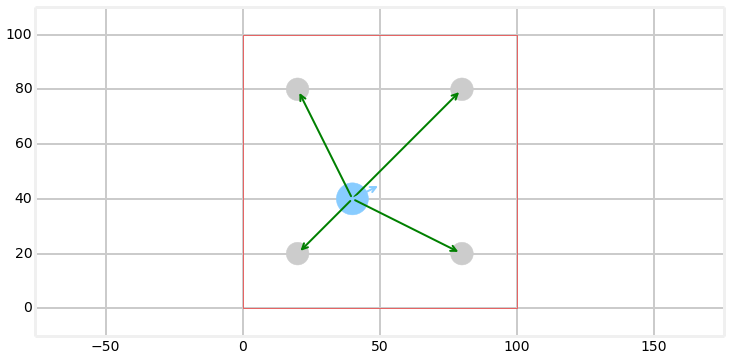

In [4]:
import numpy as np
import pylab as plt
from matplotlib.patches import Rectangle

landmark_bg = '#CCCCCC'
robot_bg = '#88CCFF'
arrow_bg = '#88FF88'

#plt.figure(figsize=(8,8), facecolor='w')
#ax = plt.axes((0, 0, 8, 8), xticks=[], yticks=[], frameon=False)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
#plt.xlim([0,100]);
#plt.ylim([0,100])
ax = plt.axes()
#ax = plt.axes((0, 0, 40, 40), xticks=[], yticks=[], frameon=False)

ax.add_patch(Rectangle((0, 0), 100, 100, edgecolor="red", facecolor="orange", fill=False))

plt.scatter ([20,20,80,80], [20,80,20,80], s=512, color=landmark_bg)
plt.scatter ([40], [40], s=1024, color=robot_bg)

ax.annotate('', xy=(20,80), xytext=(40,40),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(20,20), xytext=(40,40),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(80,80), xytext=(40,40),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(80,20), xytext=(40,40),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(50,45), xytext=(40,40),
            arrowprops=dict(arrowstyle='->',
                            ec=robot_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))

plt.axis('equal')
plt.axis([-10,110,-10,110])
plt.show()


### Using Robot Class

The following code will allow us to make a robot move along the x and y coordinates as well as in the heading direction. Take a minute to familiarize yourself with this code and then see how you can use it.

In [2]:
from math import * 
import random

landmarks  = [20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]
world_size = 100.0

class robot:
    def __init__(self):
        self.x = random.random() * world_size 
        self.y = random.random() * world_size 
        self.orientation = random.random() * 2.0 * pi 
        self.forward_noise = 0.0; 
        self.turn_noise    = 0.0; 
        self.sense_noise   = 0.0;

    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError, 'X coordinate out of bound'
        if new_y < 0 or new_y >= world_size:
            raise ValueError, 'Y coordinate out of bound'
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError, 'Orientation must be in [0..2pi]'
        self.x = float(new_x) 
        self.y = float(new_y) 
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters 
        # this is often useful in particle filters 
        self.forward_noise = float(new_f_noise);                     
        self.turn_noise    = float(new_t_noise); 
        self.sense_noise   = float(new_s_noise);

    def sense(self):
        Z = [] 
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2) 
            dist += random.gauss(0.0, self.sense_noise) 
            Z.append(dist)
        return Z

    def move(self, turn, forward):
        if forward < 0:
            raise ValueError, 'Robot cant move backwards'
        # turn, and add randomness to the turning command 
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise) 
        orientation %= 2 * pi 

        # move, and add randomness to the motion command 
        dist = float(forward) + random.gauss(0.0, self.forward_noise) 
        x = self.x + (cos(orientation) * dist) 
        y = self.y + (sin(orientation) * dist) 
        x %= world_size    # cyclic truncate 
        y %= world_size # set particle 
        res = robot()
        res.set(x, y, orientation) 
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma 
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

    def measurement_prob(self, measurement):
        # calculates how likely a measurement should be 
        prob = 1.0; 

        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2) 
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))


def eval(r, p):
    sum = 0.0; 
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0) 
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0) 
        err = sqrt(dx * dx + dy * dy) 
        sum += err
    return sum / float(len(p))

Make a object **robot** and assign it to a variable *myrobot*, and set x=10.0, y=10.0, heading=0.0

In [4]:
myrobot = robot()
myrobot.set(10.0, 10.0, 0.0)
print myrobot

[x=10.0 y=10.0 orient=0.0]


Next, make the robot move 10 meters forward and not turn

In [5]:
myrobot = robot()
myrobot.set(10.0, 10.0, 0.0)
print myrobot
myrobot = myrobot.move(0.0, 10.0)
print myrobot

[x=10.0 y=10.0 orient=0.0]
[x=20.0 y=10.0 orient=0.0]


Now, make the robot turn by $\pi/2$ and move 10 meters

In [6]:
myrobot = robot()
myrobot.set(10.0, 10.0, 0.0)
print myrobot
myrobot = myrobot.move(0.0, 10.0)
print myrobot    
myrobot = myrobot.move(pi/2, 10.0)
print myrobot

[x=10.0 y=10.0 orient=0.0]
[x=20.0 y=10.0 orient=0.0]
[x=20.0 y=20.0 orient=1.5707]


Then generate measurements with the command **sense** to give the distance to the four landmarks

In [7]:
myrobot = robot()
myrobot.set(10.0, 10.0, 0.0)
print myrobot
myrobot = myrobot.move(0.0, 10.0)
print myrobot    
myrobot = myrobot.move(pi/2, 10.0)
print myrobot
print myrobot.sense()

[x=10.0 y=10.0 orient=0.0]
[x=20.0 y=10.0 orient=0.0]
[x=20.0 y=20.0 orient=1.5707]
[0.0, 84.8528137423857, 60.0, 60.0]


#### Exercise: Move Robot

Using your interpreter, make a robot that satisfies the following requirements:

In [5]:
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses

In [8]:
#After printing senses the first time around we get the following output:
#
#   [39.0, 46.0, 39.0, 46.0]
#
#After printing sense the second time around we get the following output:
#
#    [32.0, 53.1, 47.1, 40.3]

#### Exercise: Add Noise

Set the noises as follows:

In [6]:
# forward_noise = 5.0, turn_noise = 0.1, sense_noise = 5.0
# starts at 30.0, 50.0, heading north (=pi/2)
# turns clockwise by pi/2, moves 15 meters
# senses
# turns clockwise by pi/2, moves 10 meters
# senses

#### Exercise: Create Particles

* Program a particle filter which maintains a set of N (N = 1000) random guesses as to where the robot might be.
* Each guess is a vector that contains an x-coordinate, a y-coordinate, and heading direction.
    * The heading direction is the angle the robot points relative to the x-axis.

In [7]:
# Fill in the code to assign 1,000 particles to a list p.
N = 1000
p = []

# In order to make a particle set of 1,000 particles, 
# you have to program a separate piece of code
# that assigns 1,000 of those to a list.
# Everytime you call the function robot()
# and assign it to a particle p[i]

print len(p)

0


#### Exercise: Move Robot Particles

Take each particle and simulate robot motion.

* Each particle should first turn by 0.1 and then move forward 5.0 meters.

In [10]:
N = 1000
p = []
for i in range(N):
    x = robot()
    p.append(x)

# make a new set p that is the result of the specific motion,
# turn by 0.1 and move forward 5.0 meters,
# to all of the particles in p.

## Second Half of Particle Filters

* Suppose you have a robot that sits amid four landmarks and can measure the exact distances to the landmarks.
* The below image shows the robot's location and the distances it measures, as well as "measurement noise," which is modeled as a Gaussian with a zero mean.

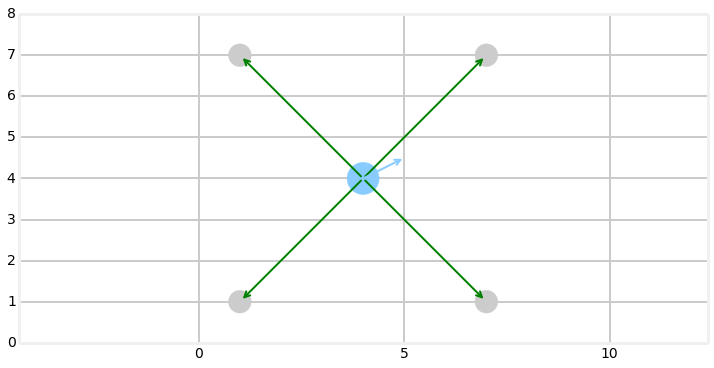

In [11]:
import numpy as np
import pylab as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

landmark_bg = '#CCCCCC'
robot_bg = '#88CCFF'
arrow_bg = '#88FF88'

#plt.figure(figsize=(8,8), facecolor='w')
#ax = plt.axes((0, 0, 8, 8), xticks=[], yticks=[], frameon=False)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
plt.xlim([0,8]);
plt.ylim([0,8])

plt.scatter ([1,1,7,7], [1,7,1,7], s=512, color=landmark_bg)
plt.scatter ([4], [4], s=1024, color=robot_bg)
ax = plt.axes()
ax.annotate('', xy=(1,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(1,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(5,4.5), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec=robot_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))

plt.axis('equal')
#plt.axis([0,8,0,8])
plt.show()

* Now we have a measurement vector that consists of the four values of the four distances from L1 to L4.
* If a particle hypothesizes that its coordinates are somewhere other than where the robot actually is (the red robot indicates the particle hypothesis), we have the situation shown below.
* The particle also hypothesizes a different heading direction.
* You can then take the measurement vector from our robot and apply it to the particle.

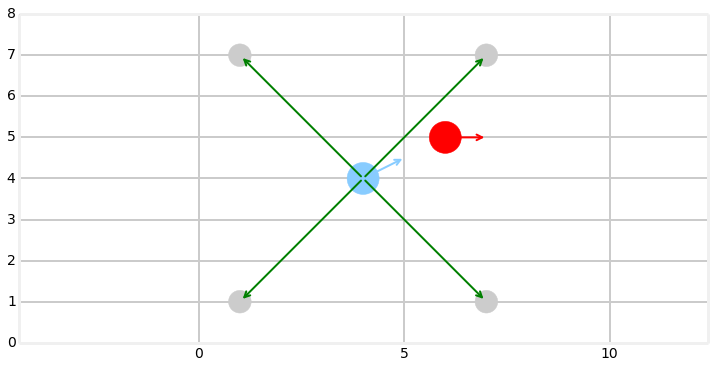

In [12]:
import numpy as np
import pylab as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

landmark_bg = '#CCCCCC'
robot_bg = '#88CCFF'
particle_bg = 'r'
arrow_bg = '#88FF88'

#plt.figure(figsize=(8,8), facecolor='w')
#ax = plt.axes((0, 0, 8, 8), xticks=[], yticks=[], frameon=False)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
plt.xlim([0,8]);
plt.ylim([0,8])

ax = plt.axes()

plt.scatter ([1,1,7,7], [1,7,1,7], s=512, color=landmark_bg)

# actual
plt.scatter ([4], [4], s=1024, color=robot_bg)
ax.annotate('', xy=(5,4.5), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec=robot_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))
# particle
plt.scatter ([6], [5], s=1024, color=particle_bg)
ax.annotate('', xy=(7,5), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec=particle_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))

ax.annotate('', xy=(1,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(1,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))

plt.axis('equal')
#plt.axis([0,8,0,8])
plt.show()

* However, this ends up being a very poor measurement vector for the particle.
* The blue indicates the measurement vector we would have predicted if the red particle actually were a good match for the robot's actual location.

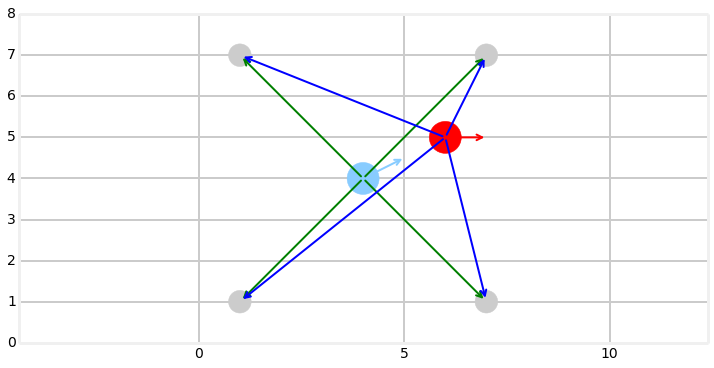

In [13]:
import numpy as np
import pylab as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

landmark_bg = '#CCCCCC'
robot_bg = '#88CCFF'
particle_bg = 'r'
arrow_bg = '#88FF88'

#plt.figure(figsize=(8,8), facecolor='w')
#ax = plt.axes((0, 0, 8, 8), xticks=[], yticks=[], frameon=False)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)
plt.xlim([0,8]);
plt.ylim([0,8])

ax = plt.axes()

plt.scatter ([1,1,7,7], [1,7,1,7], s=512, color=landmark_bg)

# actual
plt.scatter ([4], [4], s=1024, color=robot_bg)
ax.annotate('', xy=(5,4.5), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec=robot_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))

ax.annotate('', xy=(1,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(1,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,7), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,1), xytext=(4,4),
            arrowprops=dict(arrowstyle='->',
                            ec='g',
                            shrinkA=3, shrinkB=4,
                            lw=2))

# particle
plt.scatter ([6], [5], s=1024, color=particle_bg)
ax.annotate('', xy=(7,5), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec=particle_bg,
                            #shrinkA=3, shrinkB=4,
                            lw=2))

ax.annotate('', xy=(1,7), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec='b',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(1,1), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec='b',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,7), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec='b',
                            shrinkA=3, shrinkB=4,
                            lw=2))
ax.annotate('', xy=(7,1), xytext=(6,5),
            arrowprops=dict(arrowstyle='->',
                            ec='b',
                            shrinkA=3, shrinkB=4,
                            lw=2))

plt.axis('equal')
#plt.axis([0,8,0,8])
plt.show()

* The closer a particle is to the correct position, the more likely will be the set of measurements given that position.
* The mismatch of the actual measurement and the predicted measurement leads to an **importance weight** that tells how important that specific particle is.
    * The larger the weight the more important it is.

* Next we allow the particles to survive at random, but the probability of survival will be proportional to the weights, called **resampling**.
    * A particle with a larger weight will survive at a higher proportion than a particle with a small weight.
    * This means that after resampling, which is randomly drawing new particles from the old ones with replacement in proportion to the importance weight, the particles with a higher importance weight will live on, while the smaller ones will die out.
    * The "with replacement" aspect of this selection method is important because it allows us to choose the high probability particles multiple times, which causes the particles to cluster around regions with high posterior probability.

From here we need to implement

* a method of setting **importance weights**, which is related to the likelihood of a measurement
* a method of **resampling** that grabs particles in proportion to those weights

### Importance Weight

* Program a way to assign importance weights to each of the particles in the list. 

> The function **measurement_prob** accepts a single parameter, the measurement vector Z, and calculates as an output how likely the measurement is. By using a Gaussian, the function measures how far away the predicted measurements would be from the actual measurements. 

> For this function to run properly, you have to assume that there is measurement noise for the particles

#### Exercise: Assign Importance Weight

* Make a list of 1,000 elements, where each element in the list contains a number that is proportional to how important the particle is. 

In [18]:
N = 1000 
p = [] 
for i in range(N):
    r = robot() 
    r.set_noise(0.05, 0.05, 5.0) 
    p.append(r)
    
w = [] 
# write code here to use  measurement_prob to get importance weights

### Resampling

Resampling is when you are given N particles, each of which has three values and each one has a weight, w. The weights are continuous values and the sum of all of them is W.

$$W = \sum_{i=1}^Nw_i$$

Normalize the weights:

$$\alpha_i = \frac{w_i}{W}, i=1,\ldots,N$$

The sum of all alphas is:

$$\sum_{i=1}^N \alpha_i=1$$

* Resampling puts all the particles with their normalized weights into a big bag.
* Then, it draws, with replacement, N new particles by picking each particle with probability $\alpha$.
    * For example, $\alpha_2$ is drawn and becomes $p_2$, and similarly $\alpha_3$ might also be large and picked up as $p_3$. By chance you may also pick up small $\alpha_4$, to add $p_4$, and you can also pick the same one again, like $\alpha_2$, to have two versions of $p_2$, or maybe even three!
* Draw N times.
* In the end, those particles that have a high normalized weight $\alpha$ will occur more frequently in the new set.

#### Quiz: Resampling

During the process of resampling, if you randomly draw a particle in accordance to the normalized importance weights, what is the probability of drawing $p_1,\ldots, p_5$?

$$
\begin{aligned}
p_1 &: w_1=0.2, \, P(p_1)=(?)\\
p_2 &: w_2=0.4, \, P(p_2)=(?)\\
p_3 &: w_3=0.8, \, P(p_3)=(?)\\
p_4 &: w_4=0.2, \, P(p_4)=(?)\\
p_5 &: w_5=0.4, \, P(p_5)=(?)
\end{aligned}
$$


#### One Possible Algorithm

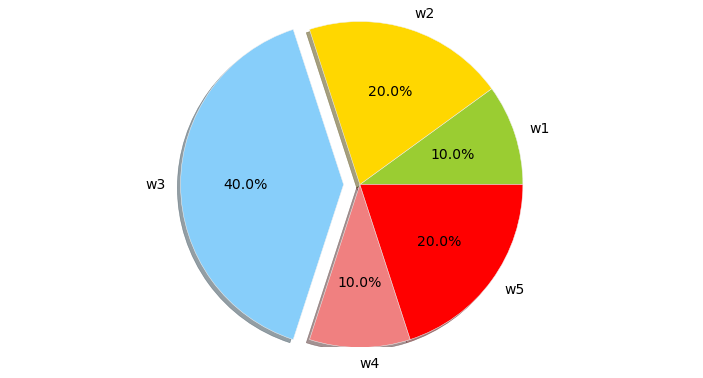

In [76]:
import matplotlib.pyplot as plt

# The slices will be ordered and plotted counter-clockwise.
labels = 'w1', 'w2', 'w3', 'w4', 'w5'
sizes = [10, 20, 40, 10, 20]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']
explode = (0, 0, 0.1, 0, 0) # only "explode" the 2nd slice (i.e. 'w2')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)#, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

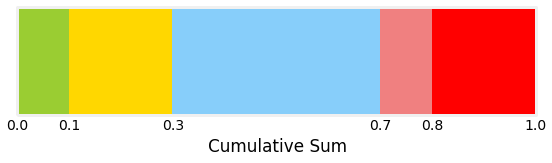

In [84]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8,3))
ax2 = fig.add_axes([0.05, 0.25, 0.9, 0.5])

cmap = mpl.colors.ListedColormap(['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red'])

bounds = [0, 0.1, 0.3, 0.7, 0.8, 1]
labels = 'w1', 'w2', 'w3', 'w4', 'w5'

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                     norm=norm,
                                     boundaries=bounds,
                                     ticks=bounds, # optional
                                     spacing='proportional',
                                     orientation='horizontal')
cb2.set_label('Cumulative Sum')
#cb2.set_ticklabels(labels)

* Represent the cumulative sum of importance weights in a bar.
    * Cumulative sum means that element zero is the weight zero, element one is the sum of weights zero and one, element two is the sum of elements zero, one and two, etc.
* Then generate random numbers in the range of 0.0 to 1.0 and do a binary search to find the weight that most closely matches that number.
* This algorithm is variously called **multinomial resampling** or **simple random resampling**. 

This is written as:

```python
    # w: list of weights
    # p: list of particles
    p3 = [] 
    cum_w[0] = w[0]
    for k in range(1,N,1):
        cum_w[k] = cum_w[k-1] + w[k]
        
    for i in range(N):
        u = random.random()
        for j in range(N):
            if cum_w[j] >= u:
                p3.apend(p[j])
                break
    p = p3
```



#### The Other Faster Possible Algorithm

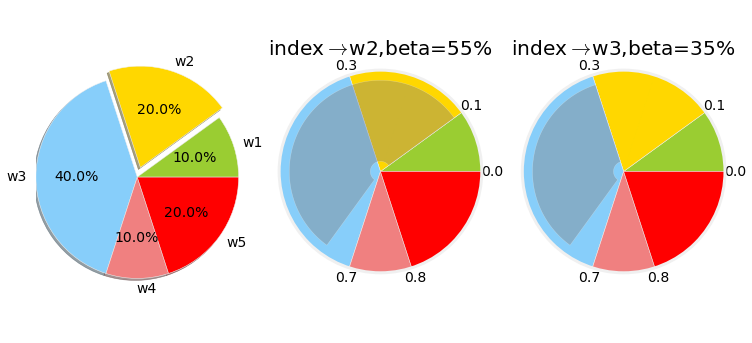

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plotpie(ax, start, width):
    bars = ax.bar(thetas, radiis, width=[s/100.0*2*pi for s in sizes], bottom=0.0
             #,labels=labels, colors=colors
             )
    betabar = ax.bar(start, 0.8, width=width, bottom=0.1
             #,labels=labels, colors=colors
             )

    bars.set_label(labels)
    for label, c, bar in zip(labels, colors, bars):
        bar.set_facecolor(c)
        bar.set_label(label)
        #bar.set_alpha(0.5)
    betabar[0].set_facecolor('gray')
    betabar[0].set_alpha(0.4)
    
    ax.set_xticks(thetas)
    ax.set_xticklabels([theta/100.0 for theta in cumsizes])


labels = 'w1', 'w2', 'w3', 'w4', 'w5'
sizes = [10, 20, 40, 10, 20]
cumsizes = [0, 10, 30, 70, 80]
thetas = [theta/100.0*2*pi for theta in cumsizes]
radiis = np.ones(len(sizes))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']

explode = (0, 0.1, 0, 0, 0) # only "explode" the 2nd slice (i.e. 'w2')
ax0 = plt.subplot(131)#, polar=True)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)#, startangle=90)
plt.axis('equal')


#fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
ax1 = plt.subplot(132, polar=True)
plt.yticks([])
ax1.set_title(r'index$\rightarrow$w2,beta=55%')
plotpie(ax1, 0.1*2*pi, 0.55*2*pi)

ax2 = plt.subplot(133, polar=True)
plt.yticks([])
ax2.set_title(r'index$\rightarrow$w3,beta=35%')
plotpie(ax2, 0.3*2*pi, 0.35*2*pi)
plt.show()

* Represent all of the particles and importance weights in a big wheel.
    * Each particle occupies a slice that corresponds to its' importance weight.
    * Particles with a bigger weight occupy more space, where particles with a smaller weight occupy less space.
* Initially, guess a particle index, uniformly from the set of all indices. Suppose that is $w_2$ indicated in the first wheel.
* Construct a variable, for example $\beta$, initialized to zero, and added a uniformly drawn continuous value between zero and $2*w_{max}$, which is the largest importance weight.
* Start at the position $w_2$, and add a beta that brings you to $w_3$, as shown in the second wheel.
* Now iterate the following loop; if the importance weights of the present particle $w_2$ doesn't suffice to reach all the way to , then subtract from the index and increase the index by increments of one. What you have done is to remove a section of w[index] (now $w_2$) and to move the index to the next w (here $w_3$), as shown in the third figure.
* By repeating this, eventually get to the point where beta is smaller than w[index] (here $w_3$ as shown in the third figure), then pick the particle associated with that index.
* Do this N times to get N particles, and we can see that particles will be chosen in proportion to their circumference on the circle.

This is written as:

```python
        p3 = [] 
        index = int(random.random() * N) 
        beta = 0.0 
        mw = max(w) 
        for i in range(N):
           beta += random.random() * 2.0 * mw
           while beta > w[index]:
               beta -= w[index]
               index = (index + 1) % N
           p3.append(p[index])
        p = p3 
```


#### Exercise: New Particle Set

* Take the list of particles and importance weights to sample N times, with replacement, N new particles with the sampling probability proportional to the importance weights. 
    * Construct a new particle set p3 = [], so that the particles in p3 are drawn from p according to the importance weights, w.

In [15]:
    p2 = []
    w = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
        w.append(p[i].measurement_prob(Z))
    p = p2

    p3 = []
    # Write code here so that the particles in p3 are drawn from p
    # according to the importance weights, w
    
    p = p3

## Programing the particle filter

Program the particle filter to run twice.

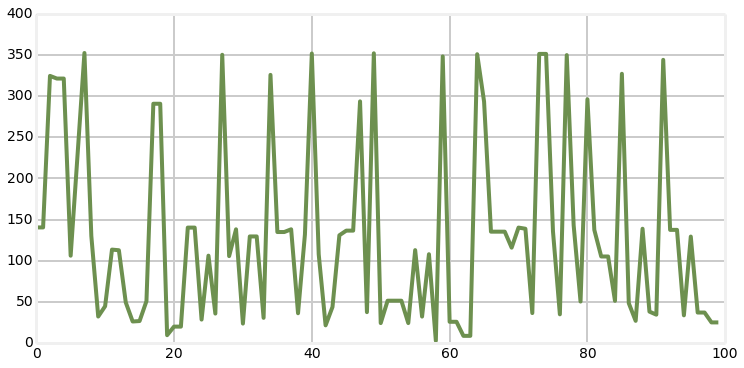

In [92]:
import matplotlib.pyplot as plt

N = 1000 
T = 2

myrobot = robot()

p = [] 
for i in range(N):
    r = robot() 
    #r.set_noise(0.01,0.01,1.0) 
    r.set_noise(0.05, 0.05, 5.0) 
    p.append(r)

for t in range(T):
    myrobot= myrobot.move(0.1, 5.0) 
    Z = myrobot.sense() 

    p2 = [] 
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2 

    w = [] 
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = [] 
    index = int(random.random() * N) 
    beta = 0.0 
    mw = max(w) 
    for i in range(N):
       beta += random.random() * 2.0 * mw
       while beta > w[index]:
           beta -= w[index]
           index = (index + 1) % N
       p3.append(p[index])
    p = p3 

#plt.plot([p[i].orientation*180.0/pi for i in range(100)])
#for i in range(N):
#    print '#', i, p[i]

What if you move ten steps forward?

[x=89.510 y=97.261 orient=0.2782]
89.1827076158 97.013774268


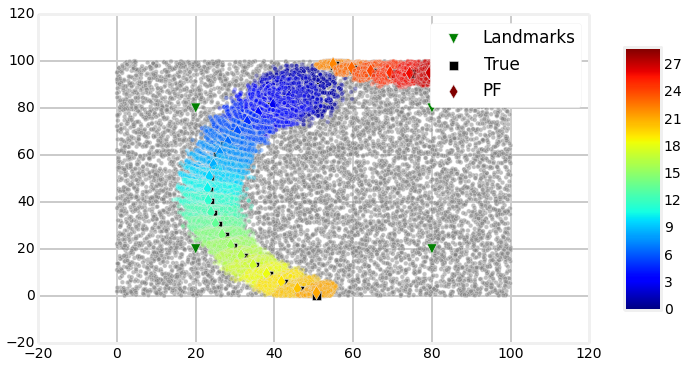

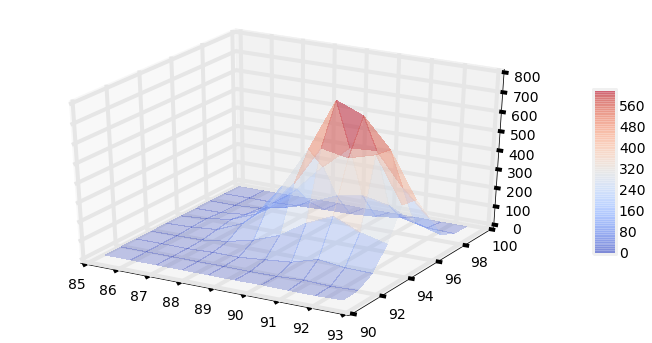

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#cm = plt.get_cmap('gist_rainbow')
cm = plt.cm.jet

N = 10000 
T = 30

myrobot = robot()

p = [] 
for i in range(N):
    r = robot() 
    #r.set_noise(0.01,0.01,1.0) 
    r.set_noise(0.05, 0.05, 5.0) 
    p.append(r)

xs = [pp.x for pp in p]
ys = [pp.y for pp in p]
c = plt.scatter(xs, ys, c='gray')
c.set_alpha(0.5)

lmc=plt.scatter([r[0] for r in landmarks], [r[1] for r in landmarks], marker='v', c='g', s=100)
mrc=plt.scatter(myrobot.x, myrobot.y, c='k', marker='s', s=75)

for t in range(T):
    myrobot= myrobot.move(0.1, 5.0) 
    Z = myrobot.sense() 

    p2 = [] 
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2 

    w = [] 
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = [] 
    index = int(random.random() * N) 
    beta = 0.0 
    mw = max(w) 
    for i in range(N):
       beta += random.random() * 2.0 * mw
       while beta > w[index]:
           beta -= w[index]
           index = (index + 1) % N
       p3.append(p[index])
    p = p3 

    xs = [pp.x for pp in p]
    ys = [pp.y for pp in p]
    xs_m = float(sum(xs))/len(xs)
    ys_m = float(sum(ys))/len(ys)
        
    #currentcolor = colors.rgb2hex(cm((t+1.0)/T))
    currentcolor = cm((t+1.0)/T)
    plt.scatter(xs, ys, c=currentcolor, alpha=0.3)
    plt.scatter(myrobot.x, myrobot.y, c='k', marker='s', s=75)
    pfc=plt.scatter(xs_m, ys_m, c=currentcolor, marker='d', s=100)

#plt.axis('equal')
plt.legend([lmc, mrc, pfc], ['Landmarks', 'True', 'PF'], loc='best')

# show colorbar
pfc.set_array(np.arange(T))
cb = plt.colorbar(pfc, shrink=0.8, aspect=7, cmap=cm)
# showing colorbar will change the color of the last estimate, so redraw it
plt.scatter(xs_m, ys_m, c=currentcolor, marker='d', s=100)

# show PDF (2D histogram)
H, xedges, yedges = np.histogram2d(xs, ys)
fig = plt.figure()
#im = plt.imshow(H, interpolation='nearest', origin='low',
#               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#fig.colorbar(im)#, shrink=0.5, aspect=5)  
#plt.axis('equal')
ax = fig.gca(projection='3d')
xcenters = xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1])
ycenters = yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1])
X,Y = np.meshgrid(xcenters, ycenters)
surf = ax.plot_surface(X, Y, H, rstride=1, cstride=1, cmap=plt.cm.coolwarm, 
                       alpha=0.3, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=7)

print myrobot
print xs_m, ys_m

* Rather than print out the particles themselves, you can print out the overall quality of the solution. 
* To do this you already have an eval code that takes in the robot position, r, and a particle set, p, to compute the average error of each particle, relative to the robot position in x and y, not orientation. 

In [ ]:
def eval(r, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        # the last part of the line is normalization for a cyclical world
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0) 
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

Take the function eval and produce a sequence of performance evaluations

In [47]:

N = 1000 
T = 10

myrobot = robot()

p = [] 
for i in range(N):
    r = robot() 
    #r.set_noise(0.01,0.01,1.0) 
    r.set_noise(0.05, 0.05, 5.0) 
    p.append(r)

for t in range(T):
    myrobot= myrobot.move(0.1, 5.0) 
    Z = myrobot.sense() 

    p2 = [] 
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2 

    w = [] 
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = [] 
    index = int(random.random() * N) 
    beta = 0.0 
    mw = max(w) 
    for i in range(N):
       beta += random.random() * 2.0 * mw
       while beta > w[index]:
           beta -= w[index]
           index = (index + 1) % N
       p3.append(p[index])
    p = p3 

    print eval(myrobot, p)


3.60349245739
4.08533592302
3.53423501432
3.31781191877
2.16083931165
1.42428895437
1.66998736603
2.04813066851
2.30006444212
2.39219418552


## What You Programmed

* You just programmed a full particle filter.
* With a very primitive robot simulator that uses landmarks as a way of taking measurements and uses 2-dimensional robot coordinates, you solved the estimation problem in just **30** lines of code.

## The Math Behind It All

Iteration of Measurement + Motion (Prediction):

* **Measurement** update: Production followed by normalization
    * Compute posterior over state, given a measurement update, that was proportional to the normalization of the probability of the measurement, given the state, multiplied by P(x)

  Bayes's rule

  $P(x|Z)=\frac{P(Z|x)P(x)}{P(Z)}$

  x=state (particle)

  Z=measurement

  $P(x|Z)=$ probability of state after measurment

  $P(x)=$ probability of state before measurment, represented by the set of particles

  $P(Z|x)=$ probability of measurment on the condition of state, importance weight 

  $P(Z)=\sum P(Z|x)P(x)$ total probability of making measurement "Z"

    * By resampling transfer the importance weight back into the set of particles so that the resulting particles $P(x|Z)$ will represent the correct posterior.


* **Motion** update: Convolution
    * Compute a posterior over distribution one time step later, and that is the convolution of the transition probability, multiplied by the prior. 
  
  Theorem of Total Probability
  
  $P(x^{t})=\sum{P(x^{t-1})P(x^{t}|x^{t-1})}$
  
  $P(x^{t}|x^{t-1})=$probability of motion from state $x^{t-1}$ to state $x^{t}$
  
    * The set of particles is written as, $P(x^{t-1})$, and your sample from the sum, $\sum$. By taking a random particle from $P(x^{t-1})$ and applying the motion model with the noise model to generate a random particle $x^{t}$. As a result you get a new particle set, $P(x^{t})$ that is the correct distribution after the robot motion.

## Some Notes

### Obtaining an estimate

1. The weighted mean
    $$P_{est}=\sum^N_{i=1}{w_ix_i}$$
1. The best particle

    $P_i$ such that $w_i=max(w_k): k=1,\ldots,N$ 

1. The weighted mean in a small window arround the best particle (also called robust mean)

Each method has its advantages and disadvantages: 
* The weighted mean fails when faced with multi-modal distributions, while the best particle introduces a discretization error.
* The best method is the robust mean but it is also the most computationally expensive.

### Timing of Resampling

* Resampling is used to solve the depletation of the population after a few iteration
    * Most of the particles have drifted far enough for their weight to become too small to contribute to the *PDF* of the moving robot.
* Measures that estimate the number of *near-zero-weight* particles
    * Coefficient of variation $cv_t^2$
    $$cv_t^2 = \frac{var(w_t(i))}{E^2(w_t(i))} = \frac{1}{N} \sum_{i=1}^N{(Nw(i)-1)^2}$$
    * Effective sample size $ESS_t$
    $$ESS_t = \frac{N}{1+cv_t}$$
* When $cv_t$ or $ESS_t$ drops below a certain threshold, usually a percentage of the number of particles N, then the particle population is resampled, eliminating (probabilistically) the ones with small weights and duplicating the ones with higher weight

### Variations on Resampling

* Using a function of weights
    * Instead of using directly the weights $w_i$ of the particles, a function of weights can be used, ex. the square root $\alpha_i = f(w_i) = \sqrt{w_i}$
    * Then the new weight $alpha_i$ are normalized so they sum up to the number of particles N
    * Then each particle is examined separately
        * if its weight is greater or equal to one, k copies of it are propagated forward ($k = \lfloor \alpha_i \rfloor$)
        * otherwise, the particle survives with probability equal to $a_i$
* Corrective resampling
    * The particle population is "injected" during the update phase with a small number of particles created directly from the sensor data independantly of the rest of the particles
* Maintaining the variance of the distribution
    * During the resampling stage a small number of particles selected uniformly from the population are propagated forward given a small weight.
    * The intuition behind this approach is to maintain the coverage of the predictive model in the particle population without affecting the accuracy.

## Particle filter example

* Assume the following Non-Linear System Model for the dependency of x and y:
$$
\begin{aligned}
x &= 0.5 x + 25x / (1 + x^2) + 8 cos(1.2(k-1))\\
y &= x^2 / 20
\end{aligned}
$$
    * x holds the actual state the world is in (the actual value we try to estimate)
    * y holds the observed variable 
                        
This is a well-known non-linear dependency, it is used for benchmarking novel, non-linear filters, see: 
> NJ Gordon, DJ Salmond, AFM Smith. *Novel approach to nonlinear/non-Gaussian Bayesian state estimation*, Radar and Signal Processing, IEE Proceedings F, 1993 

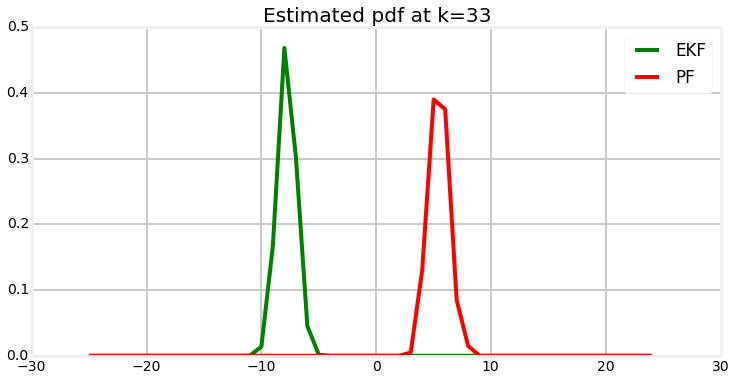

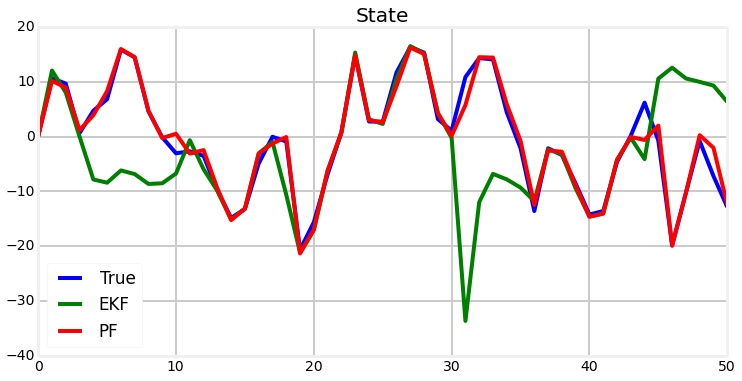

In [80]:
from __future__ import division

import scipy as sp
import math
import matplotlib.pyplot as plt

x = 0.1 # initial state
Q = 1 # process noise covariance
R = 1 # measurement noise covariance
tf = 50 # simulation length

N = 200 # number of particles in the particle filter

xhat = x
P = 2
xhatPart = x

# set the seed in order to duplicate the run exactly
sp.random.seed(3)

# Initialize the particle filter.
xpart = x + math.sqrt(P)*sp.random.normal(size=N)

xArr = [x] # true state
yArr = [x**2/20 + math.sqrt(R)*sp.random.normal()] # observation
xhatArr = [x] # state estimates of the Extended Kalman Filter
PArr = [P]
xhatPartArr = [xhatPart] # state estimates of the Particle Filter

for k in range(tf):

    ################################################
    # System simulation
    x = 0.5*x + 25*x/(1 + x*x) + 8*math.cos(1.2*k) + math.sqrt(Q)*sp.random.normal()
    y = x**2/20 + math.sqrt(R)*sp.random.normal()

    ################################################
    # Extended Kalman filter
    F = 0.5 + 25*(1 - xhat**2)/(1 + xhat**2)**2
    #P = F*P*F.T + Q
    P = F*P*F + Q
    H = xhat/10
    #K = P*H.T*(H*P*H.T + R)**(-1)
    K = P*H*(H*P*H + R)**(-1)
    xhat = 0.5*xhat + 25*xhat/(1 + xhat**2) + 8*math.cos(1.2*(k))
    xhat = xhat + K*(y - xhat**2/20)
    P = (1 - K*H)*P

    ################################################
    # Particle filter
    xpartminus = 0.5*xpart + 25*xpart/(1 + xpart**2) + 8*math.cos(1.2*(k)) + math.sqrt(Q)*sp.random.normal(size=N)
    ypart = xpartminus**2/20
    q=(1/math.sqrt(R)/math.sqrt(2*math.pi))*sp.exp(-(y-ypart)**2/2/R)
    #xpartminus = []
    #q = []
    #for i in range(N):
    #    xpartminus.append(0.5*xpart[i] + 25*xpart[i]/(1 + xpart[i]**2) + 8*math.cos(1.2*(k)) + math.sqrt(Q)*sp.random.normal())
    #    ypart = xpartminus[i]**2/20
    #    vhat = y - ypart
    #    q.append((1/math.sqrt(R)/math.sqrt(2*math.pi))*math.exp(-vhat**2/2/R))

    # Normalize the likelihood of each a priori estimate.
    qsum = sp.sum(q)
    q = [i/qsum for i in q]
    #for i in range(N):
    #    q[i] = q[i]/qsum

    # Resample.
    for i in range(N):
        u = sp.random.uniform() # uniform random number between 0 and 1
        qtempsum = 0
        for j in range(N):
            qtempsum += q[j]
            if qtempsum >= u:
                xpart[i] = xpartminus[j]
                break

    # The particle filter estimate is the mean of the particles.
    xhatPart = sp.mean(xpart)

    ################################################
    # Plot the estimated pdf's at a specific time.
    if k == 33:
        plt.figure()
        plt.grid()
        plt.title('Estimated pdf at k=%s'%k)
        m = range(-25, 25)

        ############################################
        # Kalman filter pdf
        pdf = (1/math.sqrt(P)/math.sqrt(2*math.pi)) * sp.exp(-(sp.array(m) - xhat)**2/2/P)
        plt.plot(m, pdf, 'g', label='EKF')

        ############################################
        # Particle filter pdf
        #pdf = sp.zeros((len(m),1))
        #for i in xpart:
        #    if m[0]<=i and i<=m[-1]:
        #        pdf[math.ceil(i)-1+m[-1]] += 1
        #    #for mm in m:
        #    #    if (mm <= i) and (i < mm+1):
        #    #        pdf[mm+m[-1]] = pdf[mm+m[-1]] + 1
        #    #        break
        #plt.plot(m, pdf/N, 'g', label='Particle filter')
        #print 'min, max xpart[i] at k = 20: ', min(xpart), ', ', max(xpart)
        pdf = sp.histogram(xpart, len(m), range=(m[0],m[-1]+1))#, new=True)
        plt.plot(pdf[1][0:-1], pdf[0]/N, 'r', label='PF')

        plt.legend()
        plt.grid()
        #plt.show()

    # Save data
    xArr.append(x) # true state
    yArr.append(y) # observation
    xhatArr.append(xhat) # state estimates of the Extended Kalman Filter
    PArr.append(P)
    xhatPartArr.append(xhatPart) # state estimates of the Particle Filter

t = range(tf+1)
plt.figure()
#plt.grid()
plt.title('State')
plt.plot(t, xArr, 'b', label='True')
plt.plot(t, xhatArr, 'g', label='EKF')
plt.plot(t, xhatPartArr, 'r', label='PF')
plt.legend(loc='best')

#plt.figure()
#plt.plot(sp.sqrt(PArr))
#plt.grid()
plt.show()

## Reference

* [Why Should Engineers and Scientists Be Worried About Color?](http://www.research.ibm.com/people/l/lloydt/color/color.HTM)
* [Matplotlib Gallery](http://matplotlib.org/gallery.html)
* NJ Gordon, DJ Salmond, AFM Smith. Novel approach to nonlinear/non-Gaussian Bayesian state estimation, *Radar and Signal Processing, IEE Proceedings F*, 1993
* Liu, J.S., Chen, R. and Logvinenko, T. A theoretical framework for sequential importance sampling and resampling, in *Sequential Monte Carlo Methods in Practice*. Editors: A. Doucet, J.F.G. de Freitas and N. Gordon. Cambridge University Press. 2000

In [72]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.6 32bit [GCC 4.8.2]
IPython 3.1.0
OS Linux 3.13.0 51 generic i686 with Deepin 2014.3 trusty
scipy 0.13.3
numpy 1.8.2
matplotlib 1.3.1
Thu Jun 04 10:08:00 2015 CST